#### Testing with new filter

This is with Sam's improved sperr filter.

On NCAR's Jupyterhub, environment NPL 2024b is a good option (Note: it contains an old version of ldcpy that does not support WRF data.  So make sure you have a recent version from https://github.com/NCAR/ldcpy.)


In [1]:
import os
import sys

import cf_xarray as cf
import xarray as xr
import xwrf

%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading our own ldcpy repo
sys.path.insert(0, '/glade/u/home/abaker/repos/my_ldcpy')
# suppress all of the divide by zero warnings
import warnings

# sys.path.insert(0, '/../../../')
import ldcpy

warnings.filterwarnings("ignore")

In [2]:
# set as needed
new_casper = '/glade/work/abaker/compress-libs/new_casper_plugins'
os.environ['HDF5_PLUGIN_PATH'] = new_casper

In [3]:
# check
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/abaker/compress-libs/new_casper_plugins'

In [4]:
# (wrf2d_d01_2020-07-01_10:00:00  and then for 3d also)

# get the file names
mydir = "/glade/derecho/scratch/abaker/new_sperr_psnr100/"
file2d = "wrf2d_d01_2020-07-01_10:00:00"
file3d = "wrf3d_d01_2020-07-01_10:00:00"

# original data (lossless)
campdir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_lulin/"
orig_file2d = campdir + file2d
orig_file3d = campdir + file3d

# look at new sperr file with psnr100
sp_file2d = mydir + file2d
sp_file3d = mydir + file3d

# for ref, previous sperr
# CAN'T USE THIS FILE WITH NEW FILTER
# samdir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_sam/sperr_psnr100/"
# old_sp_file2d = samdir  + file2d
# old_sp_file3d = samdir  + file3d

# this contains lat/lon info
fileconsts = campdir + "wrfconstants_usgs404.nc"

In [5]:
# file sizes? (optional to include in table when using collect datasets)
my_sizes_2d = []
my_sizes_3d = []
my_sizes_2d.append(os.path.getsize(orig_file2d))
my_sizes_3d.append(os.path.getsize(orig_file3d))

my_sp_sizes_2d = []
my_sp_sizes_3d = []

my_sp_sizes_2d.append(os.path.getsize(sp_file2d))
# my_sp_sizes_2d.append(os.path.getsize(old_sp_file2d))
my_sp_sizes_3d.append(os.path.getsize(sp_file3d))
# my_sp_sizes_3d.append(os.path.getsize(old_sp_file3d))

In [6]:
# file sizes
print(my_sizes_2d)
print(my_sp_sizes_2d)

print(my_sizes_3d)
print(my_sp_sizes_3d)

[423459547]
[198388500]
[1705618236]
[355040599]


In [7]:
# CR - compression ratios (Note: these are for the entire file, different variable may c compress with different ratios)
print("comparing to lossless!")
orig = my_sizes_2d[0]
sp_cr = []
for i in my_sp_sizes_2d:
    sp_cr.append(orig / i)
print("SPERR CR (2d): ", sp_cr)

orig = my_sizes_3d[0]
sp_cr = []
for i in my_sp_sizes_3d:
    sp_cr.append(orig / i)
print("SPERR CR (3d): ", sp_cr)

comparing to lossless!
SPERR CR (2d):  [2.1344964400658304]
SPERR CR (3d):  [4.8040090085584835]


In [8]:
# open all files as a dataset and process with xwrf for use with xarray
ds_orig_2d = xr.open_dataset(orig_file2d, engine="netcdf4").xwrf.postprocess()
ds_orig_3d = xr.open_dataset(orig_file3d, engine="netcdf4").xwrf.postprocess()

ds_sp_2d = xr.open_dataset(sp_file2d, engine="netcdf4").xwrf.postprocess()
# ds_old_sp_2d = xr.open_dataset(old_sp_file2d, engine="netcdf4").xwrf.postprocess()

ds_sp_3d = xr.open_dataset(sp_file3d, engine="netcdf4").xwrf.postprocess()
# ds_old_sp_3d = xr.open_dataset(old_sp_file3d, engine="netcdf4").xwrf.postprocess()

# coordinates
ds_const = xr.open_dataset(fileconsts, engine="netcdf4").xwrf.postprocess()

In [9]:
# make an ldcpy collection of all of this data to compare data (and pick a few variables to load).
# Passing in the file sizes is optional, but allows you to compare compression rates in the tables - here we are comparing
# to the ORIG size - the WHOLE file
combine_col_2d = ldcpy.collect_datasets(
    "wrf",
    ["T2", "U10", "Q2", "V10", "U", "V", "SNLIQ", "ACECAN", "RAINNCV", "LWUPT", "TV", "LAI"],
    [
        ds_orig_2d,
        ds_sp_2d,
    ],
    [
        "lossless",
        "new_sperr_psnr100",
    ],
    coords_ds=ds_const,
    file_sizes=my_sizes_2d + my_sp_sizes_2d,
)

dataset size in GB 0.19



In [10]:
# quick look at collection dataset
combine_col_2d

<xarray.Dataset> Size: 189MB
Dimensions:     (collection: 2, Time: 1, y: 1015, x: 1367, x_stag: 1368,
                 y_stag: 1016, snow_layers_stag: 3)
Coordinates: (12/13)
    XTIME       (Time) datetime64[ns] 8B 2020-07-01T10:00:00
  * Time        (Time) datetime64[ns] 8B 2020-07-01T10:00:00
    XLAT        (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    XLONG       (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
    XLAT_U      (y, x_stag) float32 6MB 17.64 17.65 17.66 ... 51.72 51.7 51.69
    XLONG_U     (y, x_stag) float32 6MB -122.6 -122.6 -122.5 ... -57.09 -57.04
    ...          ...
    XLONG_V     (y_stag, x) float32 6MB -122.6 -122.5 -122.5 ... -57.11 -57.06
  * x_stag      (x_stag) float64 11kB -2.734e+06 -2.73e+06 ... 2.734e+06
  * y           (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x           (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y_stag      (y_stag) float64 8kB -2.03e+06 -2.026e+06 ... 2.026e+06 2.03e+06
  * collection  (collection) <U17 136B 'lossless' 'new_sperr_psnr100'
Dimensions without coordinates: snow_layers_stag
Data variables:
    T2          (collection, Time, y, x) float32 11MB 297.2 297.2 ... 290.0
    U10         (collection, Time, y, x) float32 11MB -3.558 -3.569 ... 2.997
    Q2          (collection, Time, y, x) float32 11MB 0.01766 ... 0.009758
    V10         (collection, Time, y, x) float32 11MB -2.062 -2.079 ... 3.634
    U           (collection, Time, y, x_stag) float32 11MB -3.737 ... 3.579
    V           (collection, Time, y_stag, x) float32 11MB -2.181 ... 4.093
    SNLIQ       (collection, Time, snow_layers_stag, y, x) float32 33MB 0.0 ....
    ACECAN      (collection, Time, y, x) float32 11MB 0.0 0.0 ... -2.053e-06
    RAINNCV     (collection, Time, y, x) float32 11MB 0.0 0.0 ... -4.439e-07
    LWUPT       (collection, Time, y, x) float32 11MB 278.5 278.5 ... 195.9
    TV          (collection, Time, y, x) float32 11MB 299.6 299.6 ... 292.0
    LAI         (collection, Time, y, x) float32 11MB 0.0 0.0 ... 1.346 1.296
Attributes: (12/152)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2020-07-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    history:                         Wed May  4 13:20:54 2022: ncrcat -A -vW ...
    history_of_appended_files:       Wed May  4 13:20:54 2022: Appended file ...
    cell_measures:                   area: cell_area
    data_type:                       wrf
    file_size:                       {'lossless': 423459547, 'new_sperr_psnr1...
    weighted:                        False

In [11]:
combine_col_3d = ldcpy.collect_datasets(
    "wrf",
    ["U", "V", "QRAIN", "TK", "P_HYD"],
    [
        ds_orig_3d,
        ds_sp_3d,
    ],
    [
        "lossless",
        "new_sperr_psnr100",
    ],
    coords_ds=ds_const,
)

dataset size in GB 2.81



In [12]:
# quick look at collection dataset
combine_col_3d

<xarray.Dataset> Size: 3GB
Dimensions:     (collection: 2, Time: 1, z: 50, y: 1015, x_stag: 1368,
                 y_stag: 1016, x: 1367)
Coordinates: (12/14)
    XTIME       (Time) datetime64[ns] 8B 2020-07-01T10:00:00
  * Time        (Time) datetime64[ns] 8B 2020-07-01T10:00:00
    XLAT        (y, x) float32 6MB 17.65 17.66 17.67 17.68 ... 51.73 51.71 51.69
    XLONG       (y, x) float32 6MB -122.6 -122.5 -122.5 ... -57.17 -57.12 -57.07
    XLAT_U      (y, x_stag) float32 6MB 17.64 17.65 17.66 ... 51.72 51.7 51.69
    XLONG_U     (y, x_stag) float32 6MB -122.6 -122.6 -122.5 ... -57.09 -57.04
    ...          ...
  * z           (z) float32 200B 0.9969 0.9901 0.9821 ... 0.0161 0.009015 0.0028
  * x_stag      (x_stag) float64 11kB -2.734e+06 -2.73e+06 ... 2.734e+06
  * y           (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x           (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * y_stag      (y_stag) float64 8kB -2.03e+06 -2.026e+06 ... 2.026e+06 2.03e+06
  * collection  (collection) <U17 136B 'lossless' 'new_sperr_psnr100'
Data variables:
    U           (collection, Time, z, y, x_stag) float32 555MB -3.737 ... -1.367
    V           (collection, Time, z, y_stag, x) float32 556MB -2.181 ... -6.627
    QRAIN       (collection, Time, z, y, x) float32 555MB 0.0 0.0 ... -8.118e-10
    TK          (collection, Time, z, y, x) float32 555MB 296.8 296.8 ... 219.7
    P_HYD       (collection, Time, z, y, x) float32 555MB 1.009e+05 ... 5.257...
Attributes: (12/149)
    TITLE:                            OUTPUT FROM WRF V3.9.1.1 MODEL
    START_DATE:                      2020-07-01_00:00:00
    SIMULATION_START_DATE:           1979-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1368
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    Division:                        NCAR/RAL/HAP
    Contacts:                        CHANGHAI LIU (chliu@ucar.edu), KYOKO IKE...
    cell_measures:                   area: cell_area
    data_type:                       wrf
    file_size:                       None
    weighted:                        False

In [13]:
# grab time slice of interest (only 1)
col_2d_slice = combine_col_2d.isel(Time=0)

In [14]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "T2",
    ["lossless", "new_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,new_sperr_psnr100
mean,292.08,292.08
variance,41.777,41.777
standard deviation,6.4635,6.4635
min value,267.72,267.72
min (abs) nonzero value,267.72,267.72
max value,304.65,304.65
probability positive,1,1
number of zeros,0,0
99% real information cutoff bit,19,19
entropy estimate,0.38578,0.38566


,new_sperr_psnr100
max abs diff,0.0014038
min abs diff,0
mean abs diff,0.00025397
mean squared diff,1.8387e-13
root mean squared diff,0.00031572
normalized root mean squared diff,8.5487e-06
normalized max pointwise error,3.8011e-05
pearson correlation coefficient,1
ks p-value,1
spatial relative error(% > 0.0001),0


In [15]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "TV",
    ["lossless", "new_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,new_sperr_psnr100
mean,-3.2576e+32,-3.2576e+32
variance,3.2566e+68,3.2566e+68
standard deviation,1.8046e+34,1.8046e+34
min value,-1e+36,-1e+36
min (abs) nonzero value,261.93,261.93
max value,318.15,318.15
probability positive,0.99967,0.99967
number of zeros,0,0
99% real information cutoff bit,21,21
entropy estimate,0.28186,0.38468


,new_sperr_psnr100
max abs diff,0.002533
min abs diff,0
mean abs diff,0.0004127
mean squared diff,9.402e-14
root mean squared diff,0.00051989
normalized root mean squared diff,5.199e-40
normalized max pointwise error,2.533e-39
pearson correlation coefficient,1
ks p-value,0.040062
spatial relative error(% > 0.0001),0


In [16]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "LAI",
    ["lossless", "new_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,new_sperr_psnr100
mean,-3.2571e+32,-3.2571e+32
variance,3.2556e+68,3.2556e+68
standard deviation,1.8043e+34,1.8043e+34
min value,-9.9984e+35,-9.9984e+35
min (abs) nonzero value,0.0099983,2.0002e-12
max value,6.5742,6.5742
probability positive,0.58274,0.78572
number of zeros,5.785e+05,0
99% real information cutoff bit,20,10
entropy estimate,0.17618,0.53319


,new_sperr_psnr100
max abs diff,0.00027484
min abs diff,0
mean abs diff,3.7174e-05
mean squared diff,1.997e-15
root mean squared diff,5.3927e-05
normalized root mean squared diff,5.3935e-41
normalized max pointwise error,2.7488e-40
pearson correlation coefficient,1
ks p-value,0
spatial relative error(% > 0.0001),9.7735


In [17]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "RAINNCV",
    ["lossless", "new_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,new_sperr_psnr100
mean,0.00058815,0.00058817
variance,6.2212e-05,6.2212e-05
standard deviation,0.0078875,0.0078875
min value,0,-3.7514e-05
min (abs) nonzero value,1.3019e-12,7.5352e-13
max value,0.99651,0.99652
probability positive,0.25657,0.6163
number of zeros,1.0315e+06,0
99% real information cutoff bit,31,10
entropy estimate,0.16069,0.54717


,new_sperr_psnr100
max abs diff,4.2464e-05
min abs diff,0
mean abs diff,3.0489e-06
mean squared diff,4.4941e-16
root mean squared diff,5.3573e-06
normalized root mean squared diff,5.3761e-06
normalized max pointwise error,4.201e-05
pearson correlation coefficient,1
ks p-value,0
spatial relative error(% > 0.0001),25.277


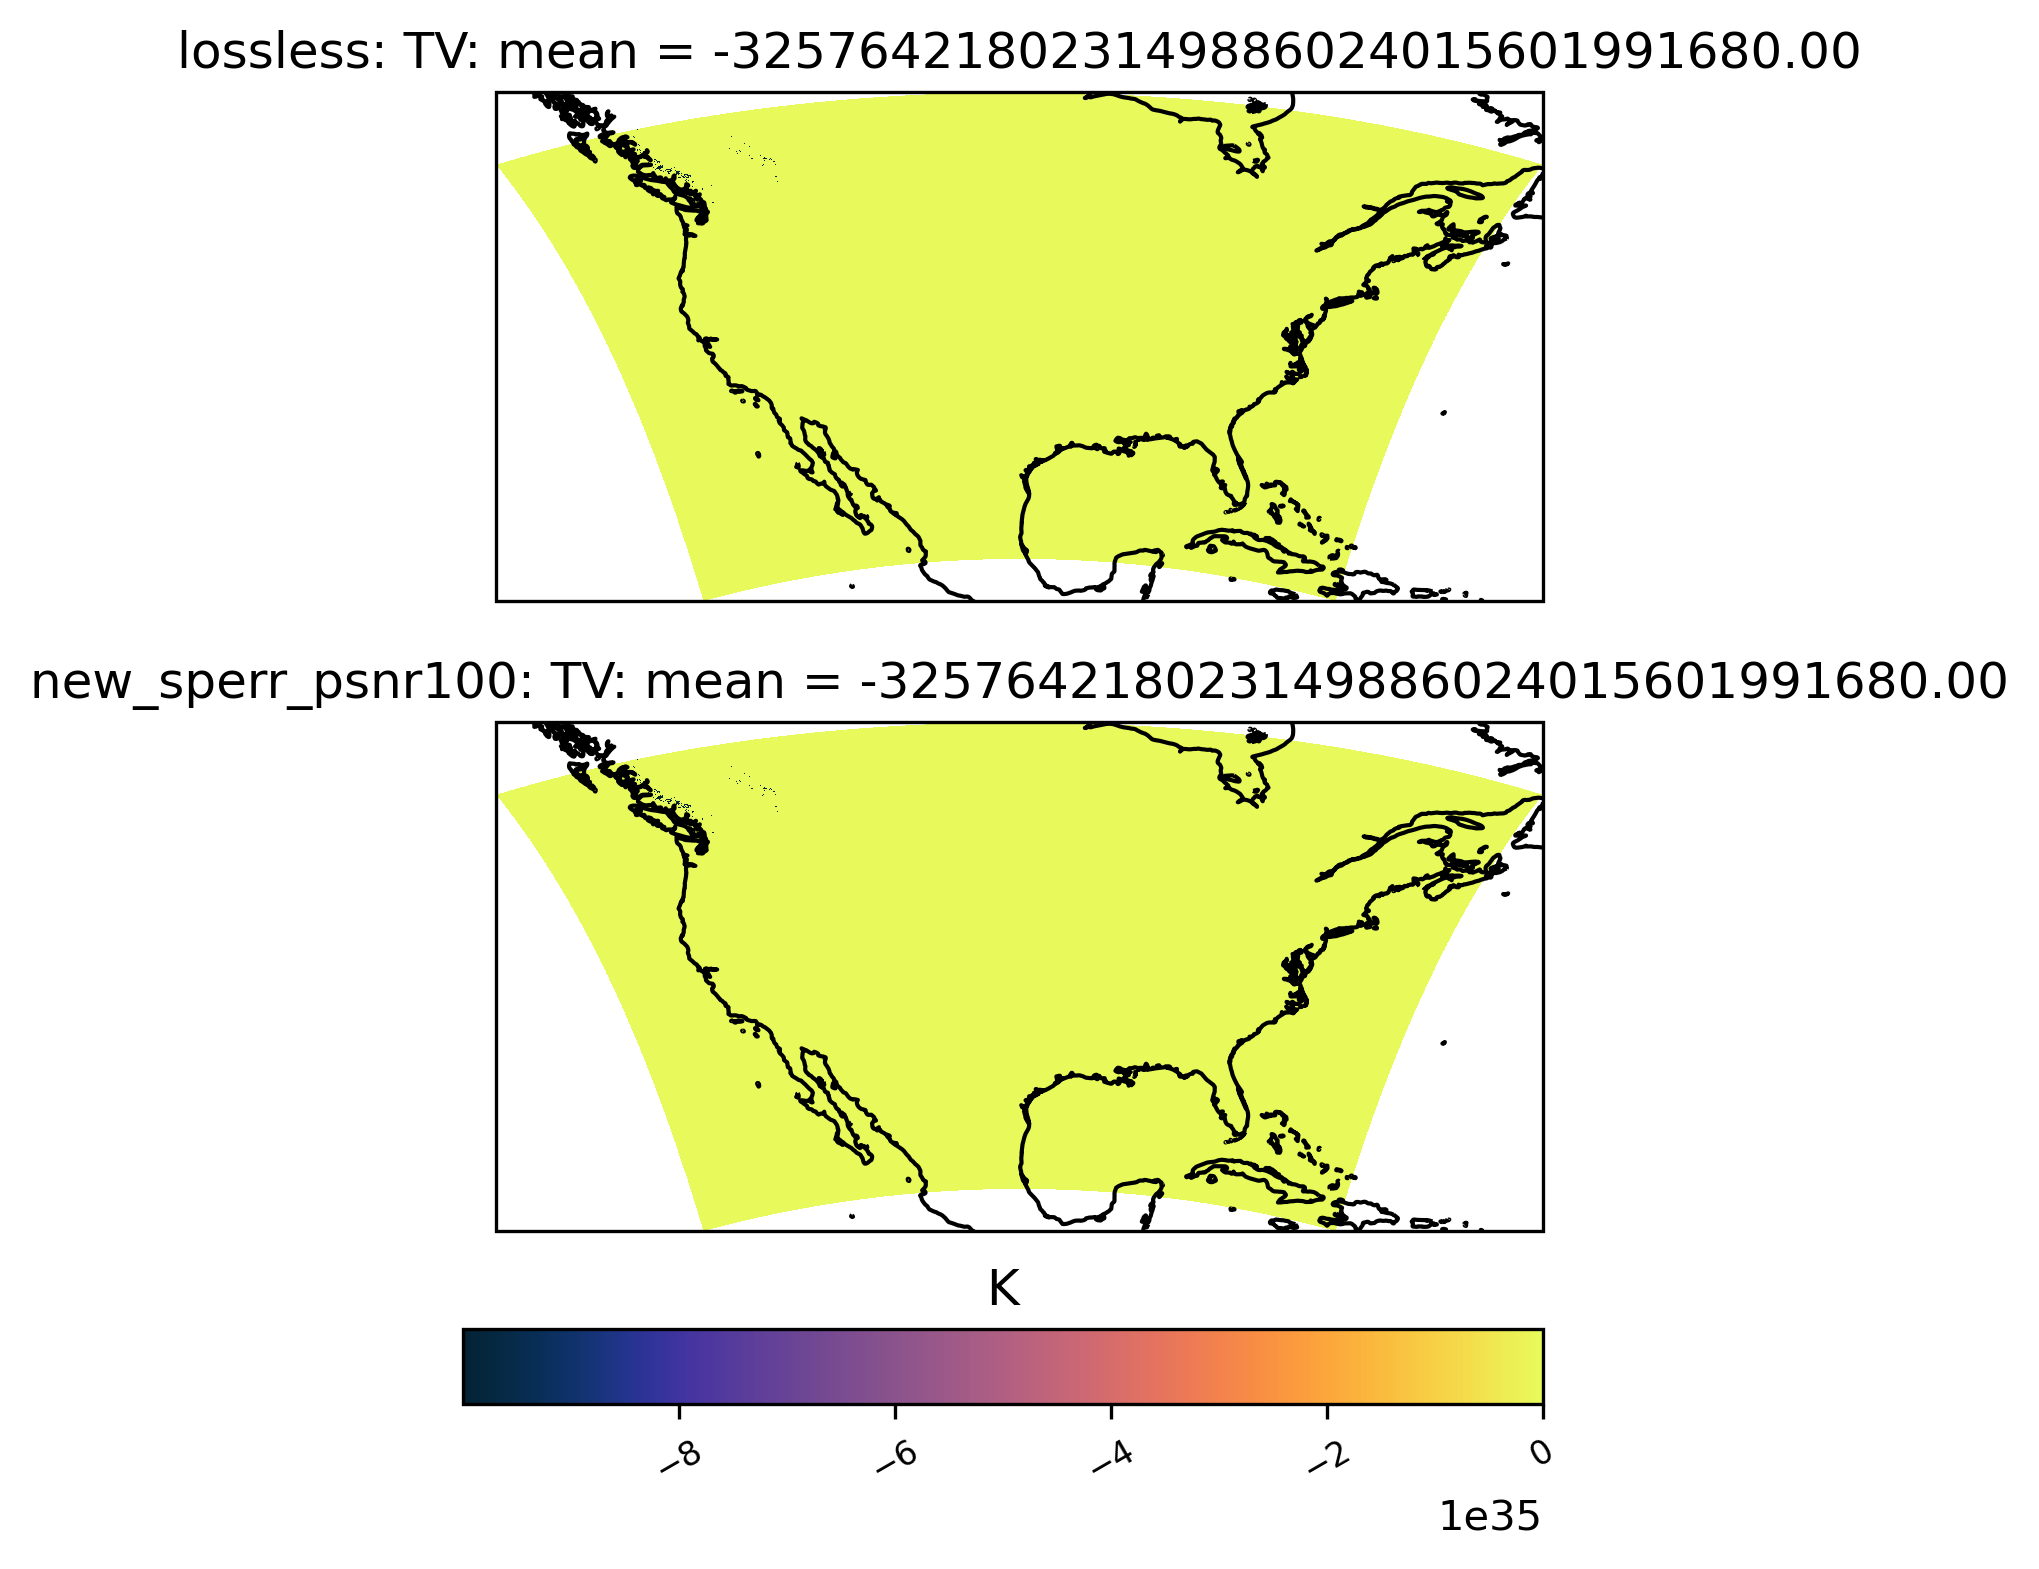

In [18]:
# plot mean TV field
ldcpy.plot(
    combine_col_2d,
    "TV",
    sets=["lossless", "new_sperr_psnr100"],
    calc="mean",
    plot_type="spatial",
    color="cmo.thermal",
    vert_plot=True,
)

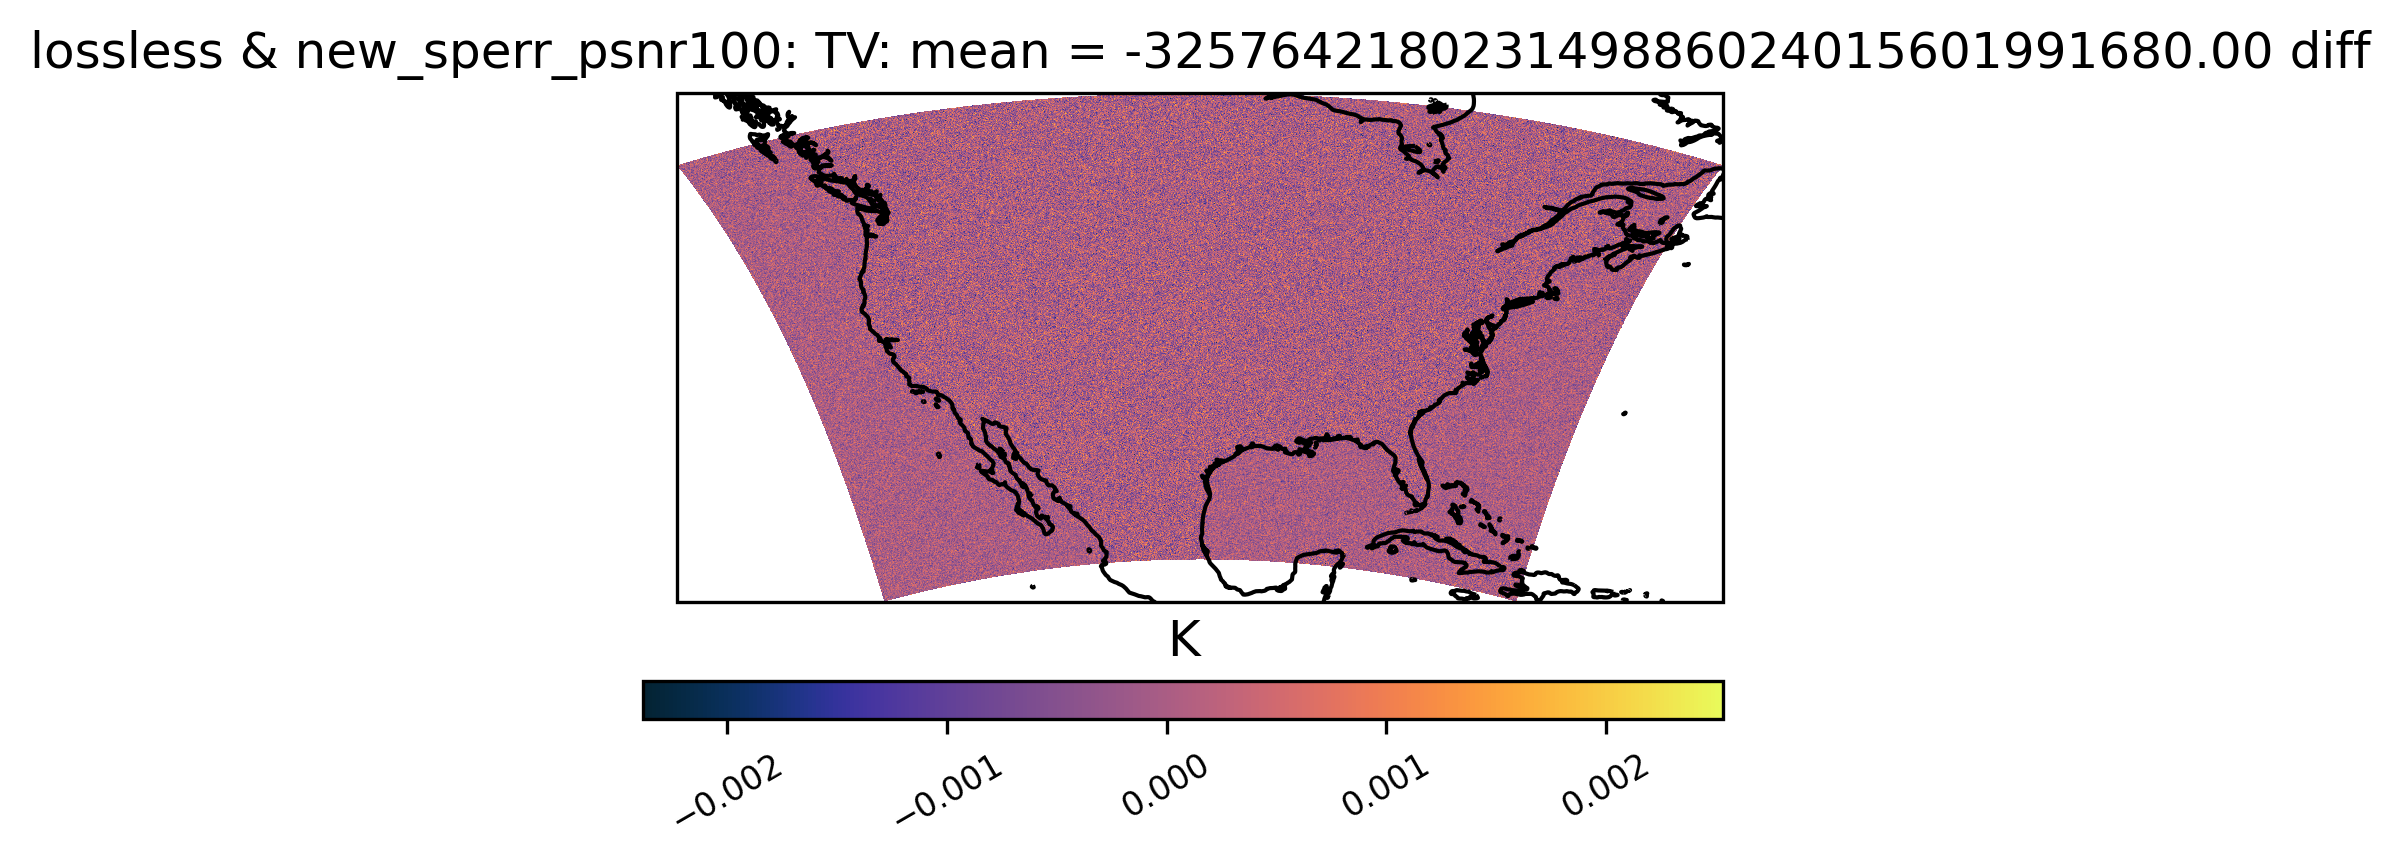

In [19]:
# Plot the differences for T2
# plot mean TV field
ldcpy.plot(
    combine_col_2d,
    "TV",
    sets=["lossless", "new_sperr_psnr100"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    color="cmo.thermal",
    vert_plot=True,
)

In [40]:
# let's look at RAINNCV - many zeros and small numbers

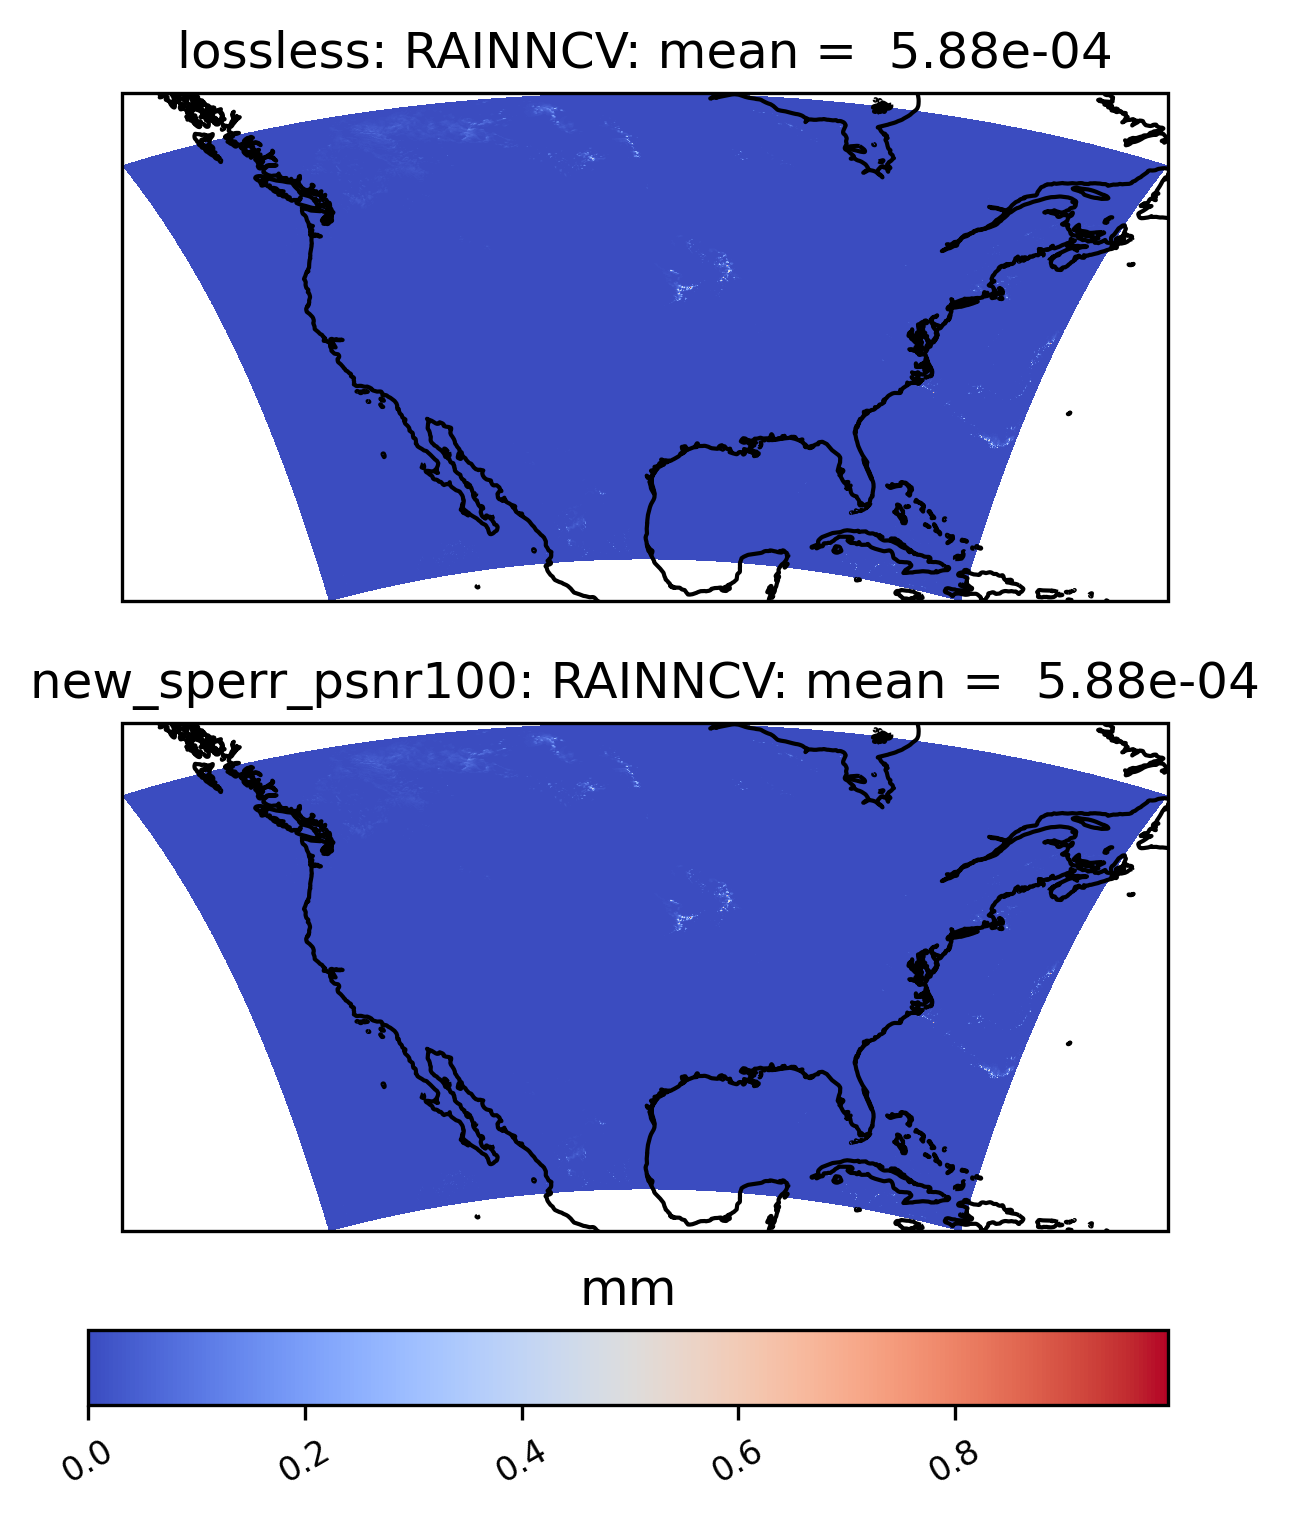

In [14]:
# do some plots for rain
ldcpy.plot(
    combine_col_2d,
    "RAINNCV",
    sets=["lossless", "new_sperr_psnr100"],
    calc="mean",
    plot_type="spatial",
    vert_plot=True,
)

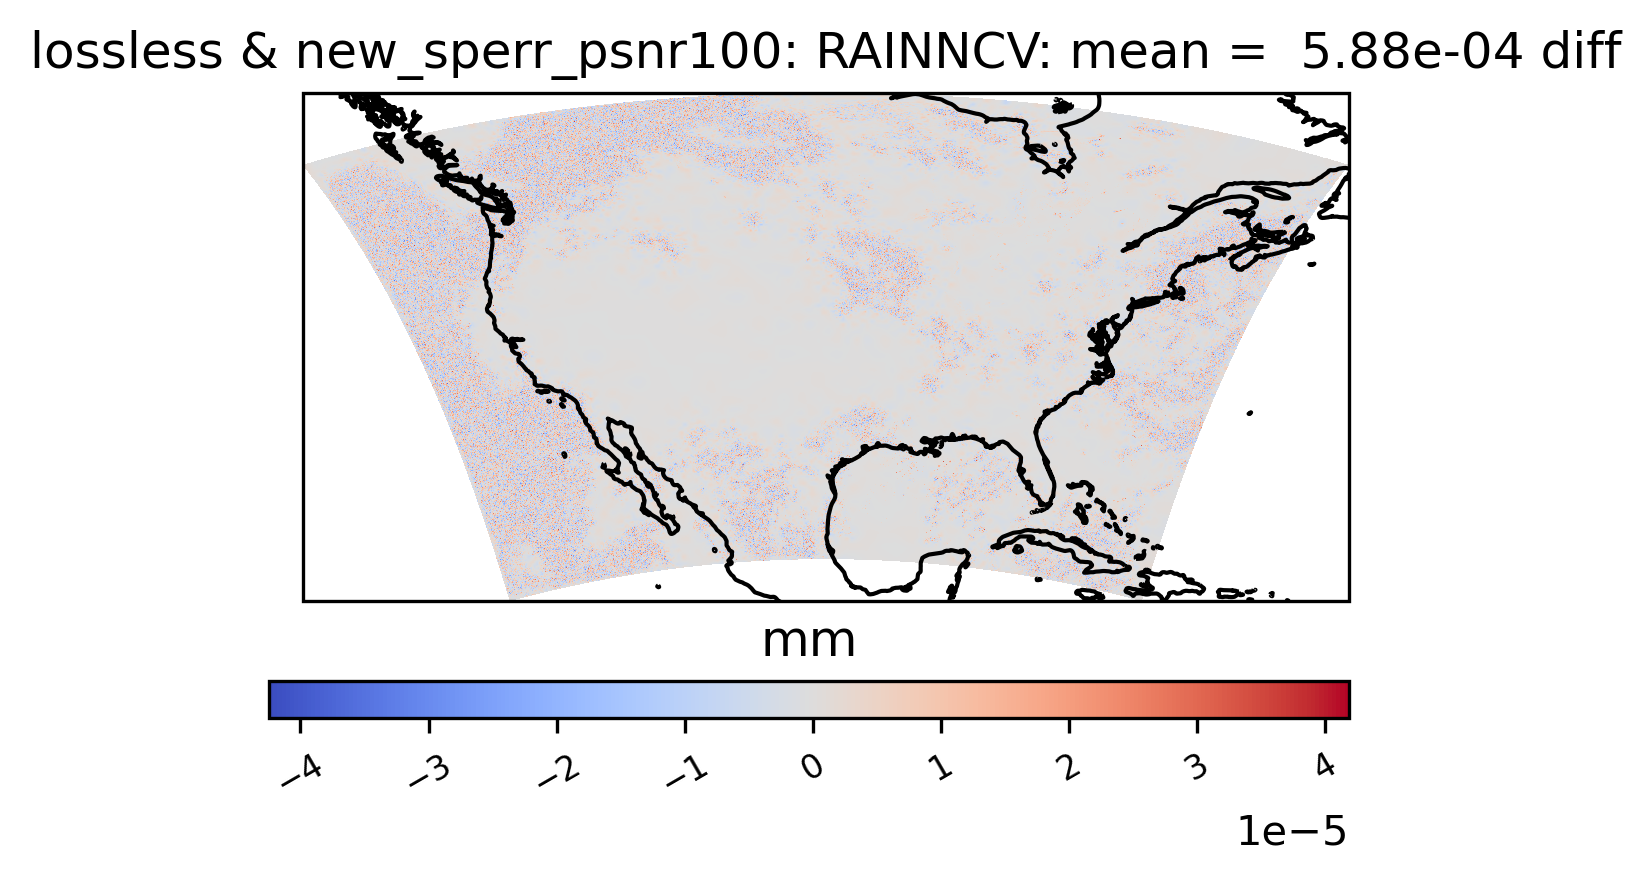

In [21]:
ldcpy.plot(
    combine_col_2d,
    "RAINNCV",
    sets=["lossless", "new_sperr_psnr100"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    vert_plot=True,
)

In [23]:
a = ds_orig_2d["LAI"].data
b = ds_sp_2d["LAI"].data

In [24]:
a

array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 1.5454102, 1.3706055,
         1.5498047],
        [0.       , 0.       , 0.       , ..., 1.4189453, 1.4897461,
         1.4555664],
        [0.       , 0.       , 0.       , ..., 1.3452148, 1.3461914,
         1.2958984]]], dtype=float32)

In [25]:
b

array([[[-1.0726335e-06, -1.0769452e-06, -1.0860484e-06, ...,
          3.5377718e-05,  2.7378474e-05,  2.1691259e-05],
        [-1.0735806e-06, -1.0778475e-06, -1.0868561e-06, ...,
          1.6916974e-05,  1.9937837e-05,  2.0549367e-05],
        [-1.0755600e-06, -1.0797328e-06, -1.0885423e-06, ...,
         -1.3932411e-05,  4.2541633e-06,  1.5166817e-05],
        ...,
        [ 8.8416044e-07,  5.9926020e-07,  2.6978515e-08, ...,
          1.5454490e+00,  1.3706902e+00,  1.5498253e+00],
        [ 8.7792853e-07,  5.9229779e-07,  1.8530296e-08, ...,
          1.4188740e+00,  1.4898446e+00,  1.4555452e+00],
        [ 8.7450138e-07,  5.8850827e-07,  1.4003771e-08, ...,
          1.3452997e+00,  1.3462282e+00,  1.2959630e+00]]], dtype=float32)